In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
from functools import partial
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
from candlesticks import candlesticks
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time_int = 30
periods = 100
multi_periods = [5, 10, 20, 40, 80, 160, 320, 640]
#multi_periods = [5, 7, 10, 12, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 160, 320, 640] 
#multi_periods = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 60, 80, 100, 120, 140, 160] 
roc_periods = [5, 10]
vol_lookback = 200
smooth = int(np.ceil(periods/4))
atr_periods = 80

In [3]:
contract = pd.read_pickle('data/minute_NQ_cont_non_active_included.pickle')
contract = contract.loc['20190101': '20191231']

In [4]:
avg_vol = contract.volume.rolling(time_int).sum().mean()
avg_vol

9915.49165665634

In [5]:
vol_candles = group_by_volume(contract, avg_vol)

In [6]:
data = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                     'close': vol_candles.close})

In [7]:
def ema(data, periods):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    up = (data.ema_fast > data.ema_slow) * 1
    down = (data.ema_fast < data.ema_slow) * 1
    return up - down

In [8]:
def breakout(data, periods):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).rename(periods, inplace=True)

In [9]:
def diff(data, periods):
    up = (data.close.diff(periods) > 0) * 1
    down = (data.close.diff(periods) < 0) * 1
    return (up - down).rename(periods, inplace=True)

In [10]:
def acc(data, periods):
    up = (data.close.pct_change(periods).pct_change(periods) > 0) * 1
    down = (data.close.pct_change(periods).pct_change(periods) < 0) * 1
    return (up - down).rename(periods, inplace=True)

In [11]:
def vol(data, vol_lookback):
    data = data.copy()
    data['returns'] = data['close'].pct_change()
    data['vol_returns'] = data['returns'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()
    data['vol_price'] = data['vol_returns'] * data['close']
    return data['vol_price']

In [12]:
vols = vol(data, vol_lookback)

In [13]:
def combine(data, multi_periods, funcs):
    result = pd.DataFrame()
    for func in funcs:
        result[func.__name__] = pd.DataFrame([func(data, p) for p in multi_periods]).T.sum(axis=1)
    return result

In [14]:
forecasts = pd.DataFrame([breakout(data, p) for p in multi_periods]).T

In [15]:
forecasts

,5,10,20,40,80,160,320
label,,,,,,,
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,-1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
7439,1,0,0,0,0,0,0
7440,1,0,0,0,0,0,0
7441,1,1,0,0,0,0,0


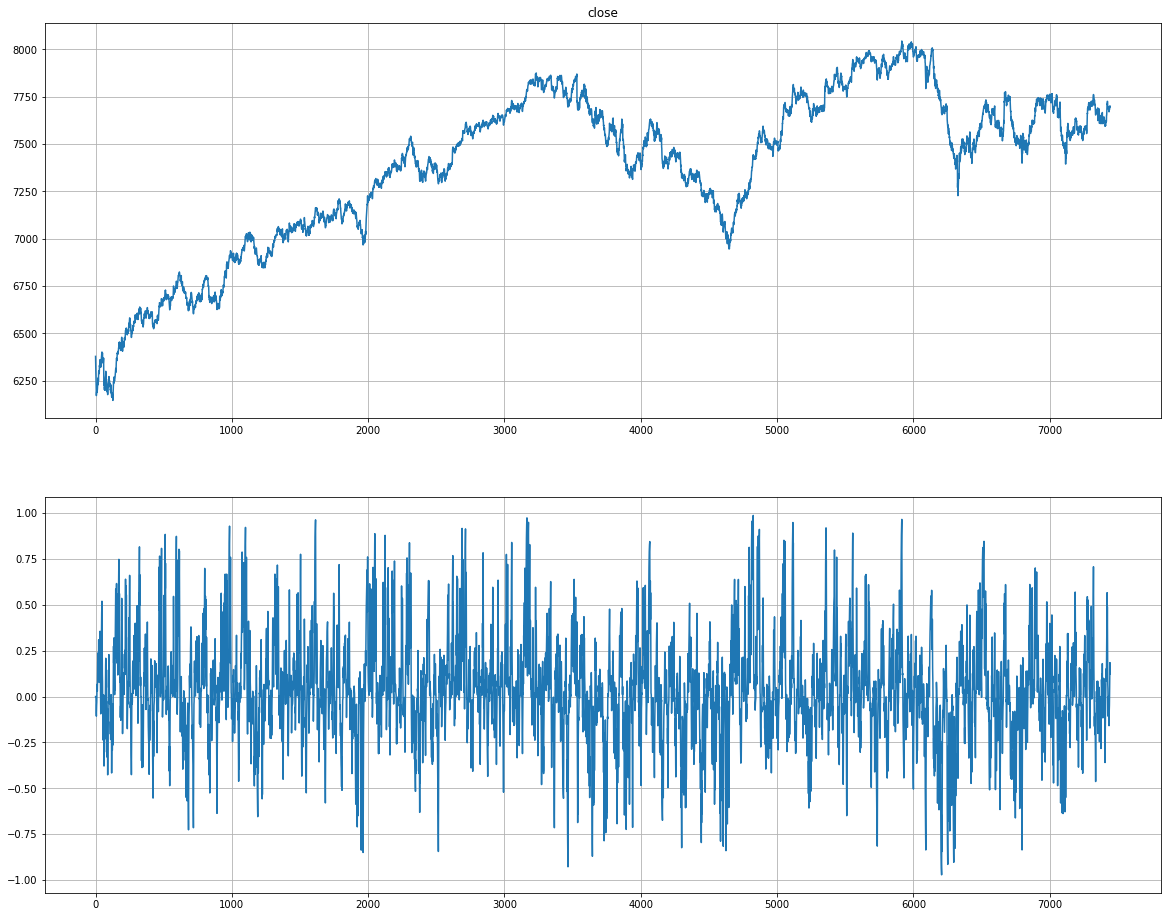

In [16]:
plot(data.close, forecasts.mean(axis=1).ewm(span=5).mean())

In [17]:
combined_forecast = forecasts.mean(axis=1).ewm(span=10).mean().rename('combined')
#combined_forecast = forecasts.mean(axis=1).rename('combined')
combined_forecast = combined_forecast*20

In [18]:
combined_forecast.abs().mean(), combined_forecast.abs().std()

(3.393161308296445, 3.139077759855342)

In [19]:
#forecasts = (combine(data, multi_periods, [breakout])*multiplier).clip(lower=-20, upper=20)
#forecasts['diff'] = pd.DataFrame([diff(data, p) for p in roc_periods]).T.mean(axis=1)
#forecasts['combined'] = forecasts.sum(axis=1).ewm(span=50).mean()

In [20]:
data = data.join(combined_forecast)
data = data.iloc[200:]

In [21]:
#plot(data[['close',  'ema','combined']])

In [22]:
output = data.set_index('date')[['open','combined']]

In [23]:
out = summary(output.open, output.combined, slip=1.5)

In [24]:
out.stats

,0,3,5,6,7,10,15,17
Annual return,0.205694,0.156787,0.0523339,-0.019502,-0.0067014,-0.0315814,0.00996512,0.00355344
Cumulative returns,0.137869,0.105796,0.0358491,-0.0135067,-0.00463197,-0.0219143,0.00687011,0.00245222
Annual volatility,0.155601,0.115768,0.0819662,0.0714725,0.0541566,0.0349084,0.0156907,0.00317069
Sharpe ratio,1.27983,1.31581,0.663168,-0.23997,-0.0972893,-0.901919,0.639744,1.12031
Calmar ratio,2.15706,2.65234,1.12459,-0.331159,-0.163947,-0.653004,1.78696,20.287
Stability,0.468832,0.863965,0.711504,0.296767,0.271128,0.148247,0.599311,0.66094
Max drawdown,-0.0953585,-0.0591126,-0.0465359,-0.0588902,-0.0408754,-0.0483632,-0.00557658,-0.000175159
Omega ratio,1.23632,1.27719,1.14505,0.951219,0.979686,0.781295,1.51103,15.0026
Sortino ratio,2.00613,2.22791,1.00131,-0.343622,-0.154915,-1.44209,1.22737,16.8514
Skew,0.140505,0.597087,-0.18769,-0.359259,0.939254,1.8966,4.59874,12.9855


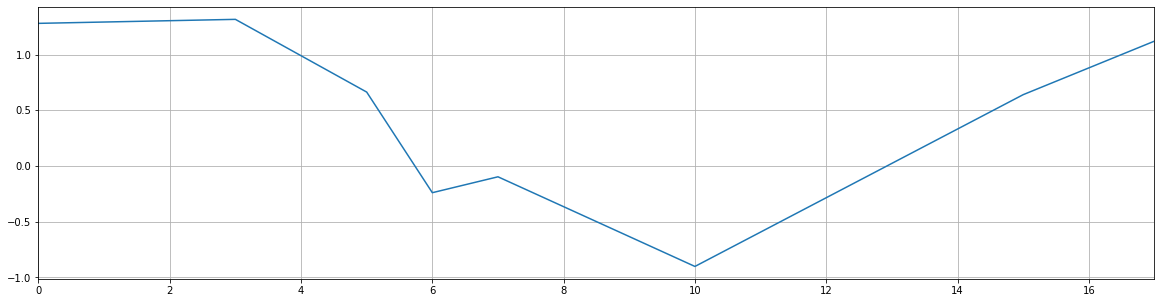

In [25]:
out.stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

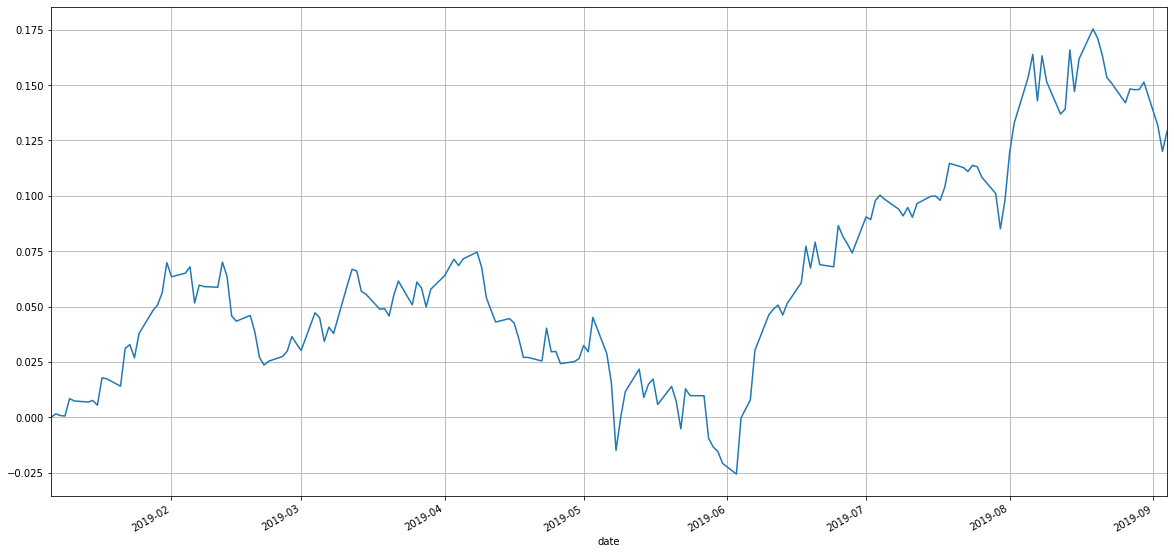

In [26]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

In [27]:
np.log(out.returns[4]+1).cumsum().plot(figsize=(20, 10), grid=True);

KeyError: 4

In [ ]:
chart_price(output.open.iloc[-1000:], output.combined.iloc[-1000:], 0);

In [ ]:
stats = pd.DataFrame()
dailys = pd.DataFrame()
returns = pd.DataFrame()
for i in [0, 1, 2, 3, 4,5]: #12, 15, 20]:
    b = v_backtester(output.open, output.combined, i)
    r = perf_var(b, False)
    stats[i] = r.stats
    dailys[i] = r.daily.balance
    returns[i] = r.daily['returns']

In [ ]:
stats